# Imports and functions

In [3]:
# !pip install neptune-client
!pip install torch==1.8.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
import os
import gc
import warnings
import IPython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import neptune.new as neptune

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader

NEPTUNE_API_TOKEN = os.environ["NEPTUNE_API_TOKEN"]
# import pickle
# NEPTUNE_API_TOKEN = pickle.load(open('../input/tokens/neptune_token.pkl', 'rb'))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [5]:
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_is_month_start'] = df[t].dt.is_month_start.astype('int')
        df[t+'_is_month_end'] = df[t].dt.is_month_end.astype('int')
        df[t+'_day'] = df[t].dt.day
        df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = (df[t+'_dayofweek'] >= 5).astype('int')
        df[t+'_quarter'] = df[t].dt.quarter


def replace_na_on_missing(x): return np.where(x.isna(), 'missing', x)

In [6]:
EPSILON = 1e-38

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))

In [7]:
def get_submittion(preds, df_test):
    submittion = df_test[['transaction_id']]
    submittion['price'] = preds
    submittion.to_csv('submittion.csv', index=False)


def get_data():
    df_2017 = pd.read_csv('data/2017.csv')
    df_2018 = pd.read_csv('data/2018.csv')
    df_test = pd.read_csv('data/2019.csv')
    # df_2017 = pd.read_csv('../input/enbysis-uk-rental/2017.csv')
    # df_2018 = pd.read_csv('../input/enbysis-uk-rental/2018.csv')
    # df_test = pd.read_csv('../input/enbysis-uk-rental/2019.csv')
    print(df_2017.shape, df_2018.shape, df_test.shape)

    df_ini = pd.concat([df_2017, df_2018])
    assert df_2017.shape[0] + df_2018.shape[0] == df_ini.shape[0]

    df_ini = reduce_mem_usage(df_ini)
    df_test = reduce_mem_usage(df_test)
    return  df_ini, df_test, #df


def preprocess_main(df):
    df['created'] = pd.to_datetime(df.created)
    preprocess_datetime(df, ['created'])
    features_objects = df.select_dtypes(['object', 'category']).columns
    features_cat = [f for f in features_objects \
                    if f not in features_str + features_address + ['transaction_id']]
    df[features_cat] = df[features_cat].astype('category')
    df[features_str] = df[features_str].astype('string')

    df.drop(TO_DROP, axis=1, inplace=True)
    df.address_id = df.address_id.astype('string')
    current_to_drop = ['created_month', 'created_quarter', 'created_hour']
    df.drop(current_to_drop, axis=1, inplace=True)
    
    
    features_num = df.select_dtypes(include=['float16', 'float32', 'float64', 'int32', 'int64']).columns
    f_all = features_cat+ features_str + features_address +features_num.tolist()
    print(len(features_cat), len(features_str), len(features_address), len(features_num),
          df.shape[1] - 2)
    assert len(features_cat) + len(features_str) + len(features_address)\
        + len(features_num) ==  df.shape[1] - 2 # created, address_id
    
    return features_cat, features_num


def categorical_to_numerical_features(df, df_test, features_cat):
    train_size = df.shape[0]
    data = pd.concat([df, df_test], axis=0)[features_cat]
    data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # cat2num = data[features_cat].cat.categories
    data[features_cat] = data[features_cat].apply(lambda x: x.cat.codes.astype('category'))

    return data.iloc[:train_size], data.iloc[train_size:]    

In [8]:
class ShelterOutcomeDataset(Dataset):
    def __init__(self, df, emb_cols):
        self.embedding_col_names = emb_cols
        self.X1 = df[emb_cols].copy().values.astype(np.int64) #categorical columns
        self.X2 = df.drop(columns=emb_cols + ['price']).copy().values.astype(np.float32) #numerical columns
        self.y = df.price.values.reshape(-1,1).copy().astype(np.float32)
        print(self.X1.shape, self.X2.shape, self.y.shape)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
    
    
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print('__ device cuda')
        return torch.device('cuda')
    else:
        print('__ device cpu')
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


device = get_default_device()

__ device cpu


In [9]:
class EmbeddingNNModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) \
                                         for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.emb_drop = nn.Dropout(0.3)
        
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 256)
        self.drops = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.lin2 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
#         self.lin3 = nn.Linear(64, 8)
#         self.bn4 = nn.BatchNorm1d(16)
        
        self.lin4 = nn.Linear(64, 1)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)] # embeddings for each feature
        x = torch.cat(x, 1) # concatenate them together
        x = self.emb_drop(x)
        
        x2 = x_cont

        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x)) # input_size -> 200
        x = F.relu(self.lin2(x)) # 200 -> 70
        
        x = self.lin4(x) # 70 -> 1
        return x
    

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

        
# the same
def train_eval_model(model, criterion, optimizer=None, dl=None):
    n, loss_sum = 0, 0
    n_mdape, loss_mdape_sum = 0, 0
    
    for x1, x2, y in dl:
        batch = y.shape[0]
        output = model(x1, x2)
        loss = criterion(output, y)
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        n += batch
        loss_sum += batch*(loss.item())
        
        with torch.no_grad():
            loss_mdape = mdape(output.cpu(), y.cpu())
            n_mdape += batch
            loss_mdape_sum += batch*(loss_mdape.item())
        
    return loss_sum/n, loss_mdape_sum/n_mdape

# the same
def get_prediction(data, model, embedded_col_names, flag_plot=False):
    dl = get_dataloader(data, embedded_col_names, params_neptune['batch_size'], 
                        device=device, flag_train=False)
    preds = []
    with torch.no_grad():
        for x1, x2, y in dl:
            out = model(x1, x2)
            preds.append(out)
    preds = pd.Series([item.item() for sublist in preds for item in sublist])
    if data.price.notna().all():
        print(mdape(data.price.values, preds))
    if flag_plot:
        fig, axes = plt.subplots(1,2, figsize=(10,5))
        temp = pd.concat([preds, val[['price']].reset_index(drop=True)], axis=1)
        temp.columns = ['pred', 'true']
        temp.plot.scatter(x='true', y='pred', ax=axes[0])
        axes[0].set_title('All data')
        sns.regplot(x='true', y='pred', data=temp[temp.true <= temp.pred.max()], 
                    line_kws={'color':'black', 'label': 'regression'}, ax=axes[1])
        plt.plot([0, temp.pred.max()], [0, temp.pred.max()], color='black',linestyle='dashed', label='exact pred')
        axes[1].legend()
        axes[1].set_title('Data with price < 1e6')
        return preds, fig
    return preds

# the same
def train_loop(model, train_dl, valid_dl, params_neptune, 
                optimizer, flag_neptune=False, flag_val=True, flag_print=True):
    criterion = nn.L1Loss()
    train_losses = np.zeros((2, params_neptune['iterations']))
    val_losses = np.zeros((2, params_neptune['iterations']))

    if flag_val: to_end = ' | '
    else: to_end='\n'
    if flag_print:
        print('\ttrain\t\t\tval')
        print('\tloss\tmdape\t\tloss\tmdape')
    
    if flag_neptune:
        run = neptune.init(project='declot/Enbysis-UK-Rental', 
                            api_token=NEPTUNE_API_TOKEN,
                            source_files=['3_nn_embedding.ipynb', 'requirements.txt'])
        run['parameters'] = params_neptune
        run["sys/tags"].add(['NN embed', 'NN'])
        run['model'] = model

    for i in range(params_neptune['iterations']): 
        model.train()
        t_loss = train_eval_model(model, criterion, optimizer, train_dl)
        train_losses[:, i] = np.array(t_loss)
        if flag_print: print(f'({i:>3}) {t_loss[0]:.2e}\t{t_loss[1]:>.4e}', end=to_end)
        if flag_val:
            model.eval()
            v_loss = train_eval_model(model, criterion, optimizer=None, dl=valid_dl)
            val_losses[:, i] = np.array(v_loss)
            
            if flag_print: print(f'{v_loss[0]:.2e}\t{v_loss[1]:>.4e}')
            if flag_neptune:
                run['loss/train'].log(t_loss[0])
                run['mdape/train'].log(t_loss[1])
                run['loss/val'].log(v_loss[0])
                run['mdape/val'].log(v_loss[1])
                run['val/mdape'] = np.min(val_mdapes)
                run['cv/mdape_iter'] = np.argmin(val_mdapes) + 1

    if flag_val:
        preds, fig = get_prediction(val, model, valid_dl.dl.dataset.embedding_col_names, True)
    if flag_neptune: 
        run['pred_true'].upload(fig)
        run['val/mdape'] = mdape(val.price.values, preds)
        run.stop()
        
    return train_losses, val_losses

In [17]:
# + embedded_col_names
def get_dataloader(data, embedded_col_names, batch_size, device, flag_train=True):
    data_ds = ShelterOutcomeDataset(data, embedded_col_names)
    data_dl = DataLoader(data_ds, batch_size=batch_size, shuffle=flag_train)
    data_dl = DeviceDataLoader(data_dl, device)
    return data_dl 

# the same
def model_NN_emb(train, val, model,  embedding_info, params_neptune, 
                 optimizer, flag_neptune=False):
    device = get_default_device()
    train_dl = get_dataloader(train, embedding_info['embedded_col_names'], params_neptune['batch_size'], device)
    valid_dl = get_dataloader(val, embedding_info['embedded_col_names'], params_neptune['batch_size'], device)
                
    # model = ShelterOutcomeModel(embedding_info['embedding_sizes'], train_dl.dl.dataset.X2.shape[1])
    to_device(model, device)

    train_loop(model, train_dl, valid_dl, params_neptune, 
                optimizer, flag_neptune=flag_neptune)
    return model

def model_NN_emb_cv(df, df_test, model, cv, params_neptune, 
                 optimizer, flag_neptune=False):
    device = get_default_device()
    to_device(model, device)
    
    train_losses = np.zeros((2, params_neptune['iterations'], cv.get_n_splits()))
    val_losses = np.zeros((2, params_neptune['iterations'], cv.get_n_splits()))

    for i, (train_idx, val_idx) in enumerate(cv.split(df)):
        data = df.iloc[np.concatenate((train_idx, val_idx), axis=0)]
        train, val, _, _, embedding_info = preprocess_total(data, df_test,
                                                           (train_idx, val_idx))   
        features = features_str + features_address #+ ['price']
        train.drop(features, axis=1, inplace=True)
        val.drop(features, axis=1, inplace=True)
        assert (train.isna().sum() == 0).all()
        
        train_dl = get_dataloader(train, embedding_info['embedded_col_names'], params_neptune['batch_size'], device)
        valid_dl = get_dataloader(val, embedding_info['embedded_col_names'], params_neptune['batch_size'], device)
                
        model.apply(init_weights)
        to_device(model, device)
        t_loss, v_loss = train_loop(model, train_dl, valid_dl, params_neptune, 
                                    optimizer, flag_neptune=False, flag_print=False)
        train_losses[:,:,i] = t_loss
        val_losses[:,:,i] = v_loss
        
    
    return model, train_losses, val_losses

In [11]:
def drop_features(features_drop, *dfs, features_list=None):
    for df in dfs:
        df.drop(features_drop, axis=1, inplace=True)
    if features_list is not None:
        features_list = [f for f in features_list if f not in features_drop]
        return features_list


def fill_na_by_means_of_group(train, val, test, f_all):
    
    def fill_na_by_given_values(train, means, f_all):
        temp = train[f_all + ['postcode_sector']].merge(means, on='postcode_sector', how='left')
        assert temp.shape[0] == train.shape[0]
        f_all_mean = means.drop('postcode_sector', axis=1).columns
        for f, f_mean in tqdm(zip(f_all, f_all_means)):
            print(f, f_mean)
            train[f] = temp.groupby('postcode_sector').apply(lambda x: x[f].fillna(x[f_mean])).droplevel(0).sort_index()
        train[f_all] = train[f_all].fillna(0)
        return train
        
    f_all = np.array(f_all)[train[f_all].isna().any()].tolist()
    temp = train[f_all + ['postcode_sector']]
    print(f'# of features to fill with postcode_sector means: {len(f_all)}')
    temp[f_all] = temp[f_all]. astype('float')
#     transf = CrossFeatures(['postcode_sector'], f_all, split_size=2                      )
#     transf.fit_transform(temp)
    f_all_means = ['postcode_sector' + '_' + f for f in f_all]
    
    temp = temp.groupby('postcode_sector', as_index=False).mean()
    temp.columns = ['postcode_sector']  + f_all_means

    train = fill_na_by_given_values(train, temp[f_all_means + ['postcode_sector']], f_all)
    val = fill_na_by_given_values(val, temp[f_all_means + ['postcode_sector']], f_all)
#     test = fill_na_by_given_values(test, temp[f_all_means + ['postcode_sector']], f_all)
     
    return train, val, test
    
def get_prev_price(train, val, test):
    train.sort_values('created', inplace=True)
    train.flat = train[['flat']].apply(replace_na_on_missing)
    val.flat = val[['flat']].apply(replace_na_on_missing)
    train['address'] = train.address_id.astype('string') + train.flat
    val['address'] = val.address_id.astype('string') + val.flat
    test['address'] = test.address_id.astype('string') + df_test.flat

    fs = ['created', 'duration', 'price']
    train['prev_price'] = train.groupby(['address'], sort=False).price.shift(1)
    train_prev_price = train.groupby(['address'], sort=False).price.last()
    train_prev_price.name = 'prev_price'
    train_prev_price = train_prev_price.reset_index()
    
    val = val.merge(train_prev_price, on='address', how='left')
    test = test.merge(train_prev_price, on='address', how='left')

    train.drop(['created', 'address_id', 'address'], axis=1, inplace=True)
    val.drop(['created', 'address_id', 'address'], axis=1, inplace=True)
    test.drop(['created', 'address_id', 'address'], axis=1, inplace=True)
    
    return train, val, test    



# Model

In [12]:
features_str = ['epc_windows_description',
                'epc_walls_description',
                'epc_roof_description',
                ]
features_address = [
                    'street', 
#                     'city', 
                'building_number', 'flat',
                'building_name',
#                 'postcode_sector',
                'postcode']
TO_DROP = ['transaction_id']

features_time_dependent = [
#                            'old_new', 
#                            'ppd_category',
                           'created_is_month_end', 
                           'epc_lighting_cost_current',
                           'epc_energy_consumption_current', 
                           'created_dayofweek',
                           'epc_heating_cost_current', 
                           'created_day', 
                           'total_floor_area']
features_cat_corr =  [
#                       'duration', 
                      'epc_built_form', 
                      'ppd_category', 
#                       'epc_property_type'
                     ]


def preprocess_total(df, df_test, idx):
    df, df_test = df.copy(), df_test.copy()
    features_cat, features_num = preprocess_main(df)
    _ = preprocess_main(df_test)
    df_test['price'] = np.nan
    
    fs = ['created', 'address_id']
    df.drop(fs, axis=1, inplace=True)
    df_test.drop(fs, axis=1, inplace=True)
        
    # drop features which are time depended
#     features_cat = drop_features(features_time_dependent, df, df_test, features_list=features_cat)
    
    # drop cat features wich are hight correlated
#     features_cat = drop_features(features_cat_corr, df, df_test, features_list=features_cat)
    
    # nans in cat
    df[features_cat], df_test[features_cat] = categorical_to_numerical_features(df, df_test,
                                                                           features_cat)
    # fill na by 0
    # df[features_num] = df[features_num].fillna(0)
    # df_test[features_num] = df_test[features_num].fillna(0)

    # get info about embedding features
    df[features_cat] = df[features_cat].astype('category')
    embedded_cols = {n: len(col.cat.categories) for n,col in df[features_cat].items() if len(col.cat.categories) > 2}
    embedded_col_names  = list(embedded_cols.keys())
    embedding_sizes = [(c, min(50, (c+1)//2)) for _,c in embedded_cols.items()]
    embedding_info = dict(embedded_col_names=embedded_col_names,
                        embedding_sizes=embedding_sizes)
    print(f'''# features in ohe: {np.sum([x[0] for x in embedding_sizes])}
# features in embedding: {np.sum([x[1] for x in embedding_sizes])}''')

    # get all continues features
    f_all = df.drop(embedded_col_names + ['price'], axis=1)\
            .select_dtypes(exclude=['object', 'string']).columns.tolist()
    
    # create new features for na values 
#     f_isna = [f+'_isna' for f in f_all]
#     df[f_isna] = df[f_all].isna().astype('int')
#     df_test[f_isna] = df_test[f_all].isna().astype('int')

    if idx is None:
        train = df
        val = None
    else:
        train_idx, val_idx = idx
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
    
    # add feature with previously prices
#     train, val, df_test = get_prev_price(train, val, df_test)
#     f_all = train.drop(embedded_col_names + ['price'], axis=1)\
#             .select_dtypes(exclude=['object', 'string']).columns.tolist()
    
    ss = StandardScaler().fit(train[f_all])
    train[f_all] = ss.transform(train[f_all])
    if idx is not None: val[f_all] = ss.transform(val[f_all])
    df_test[f_all] = ss.transform(df_test[f_all])
    
    # fill na
#     train, val, df_test = fill_na_by_means_of_group(train, val, df_test, f_all)
    imp = SimpleImputer()
    train[f_all] = imp.fit_transform(train[f_all])
    if idx is not None: val[f_all] = imp.transform(val[f_all])
    df_test[f_all] = imp.transform(df_test[f_all])
    
    # clip upper price
#     upper = train.price.quantile(0.99)
#     train.price.clip(upper=upper, inplace=True)
#     print('upper price value after clip (train), 1e5:', upper/1e5)
#     print('max price value (valid), 1e5:', val.price.max()/1e5)

    return train, val, df_test, features_cat, embedding_info

In [13]:
df_ini, df_test = get_data()
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df_ini.shape[0]),
                                size=100_000, replace=False)
df = df_ini.iloc[idx]

(992212, 43) (986565, 43) (28323, 42)
Mem. usage decreased to 471.78 Mb (29.0% reduction)
Mem. usage decreased to  6.43 Mb (29.2% reduction)


In [14]:
cv_folds = TimeSeriesSplit(n_splits=5)
idx = list(cv_folds.split(df, df.price))[-1]

train, val, test, features_cat, emb_info = preprocess_total(df, df_test, idx)
features = features_str + features_address #+ ['price']
train.drop(features, axis=1, inplace=True)
val.drop(features, axis=1, inplace=True)
test.drop(features, axis=1, inplace=True)

assert (train.isna().sum() == 0).all()

embedding_col_names = emb_info['embedded_col_names']

15 3 5 22 45
15 3 5 21 44
# features in ohe: 8409
# features in embedding: 145


__ device cpu
n continues features: 24
n features: 169
__ device cpu
15 3 5 22 45
15 3 5 21 44
# features in ohe: 8127
# features in embedding: 143
(16670, 12) (16670, 24) (16670, 1)
(16666, 12) (16666, 24) (16666, 1)


(16666, 12) (16666, 24) (16666, 1)
0.3421212859830387
15 3 5 22 45
15 3 5 21 44
# features in ohe: 8252
# features in embedding: 144
(33336, 12) (33336, 24) (33336, 1)
(16666, 12) (16666, 24) (16666, 1)
(16666, 12) (16666, 24) (16666, 1)
0.2992824011926135
15 3 5 22 45
15 3 5 21 44
# features in ohe: 8323
# features in embedding: 144
(50002, 12) (50002, 24) (50002, 1)
(16666, 12) (16666, 24) (16666, 1)
(16666, 12) (16666, 24) (16666, 1)
0.24465910947170647
15 3 5 22 45
15 3 5 21 44
# features in ohe: 8372
# features in embedding: 144
(66668, 12) (66668, 24) (66668, 1)
(16666, 12) (16666, 24) (16666, 1)
(16666, 12) (16666, 24) (16666, 1)
0.23577660245961024
15 3 5 22 45
15 3 5 21 44
# features in ohe: 8409
# features in embedding: 145
(83334, 12) (83334, 24) (83334, 1)
(16666, 12) (16666, 24) (16666, 1)
(16666, 12) (16666, 24) (16666, 1)
0.17853657348580204
CPU times: user 8min 59s, sys: 2.42 s, total: 9min 1s
Wall time: 27min 43s


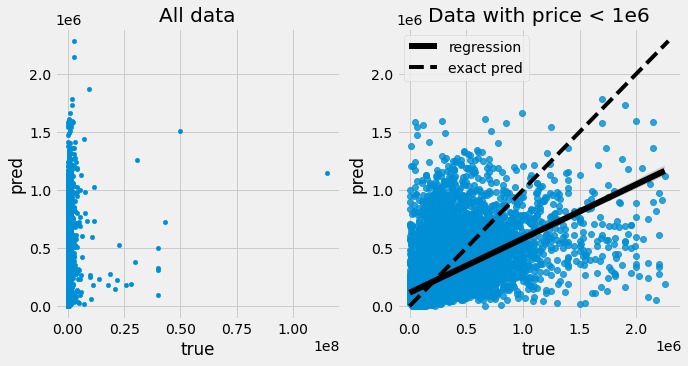

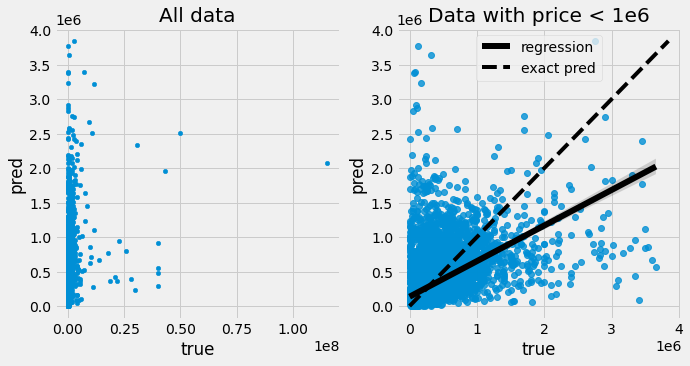

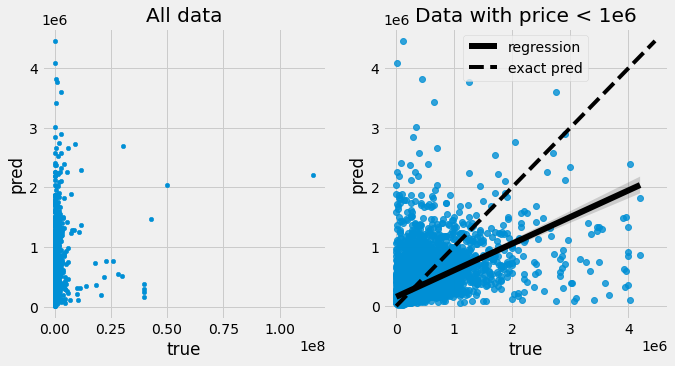

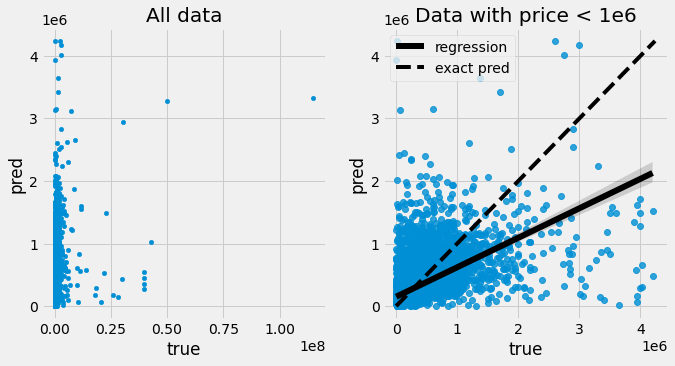

Exception ignored in: <function tqdm.__del__ at 0x7fed3c8315f0>
Traceback (most recent call last):
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='success')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


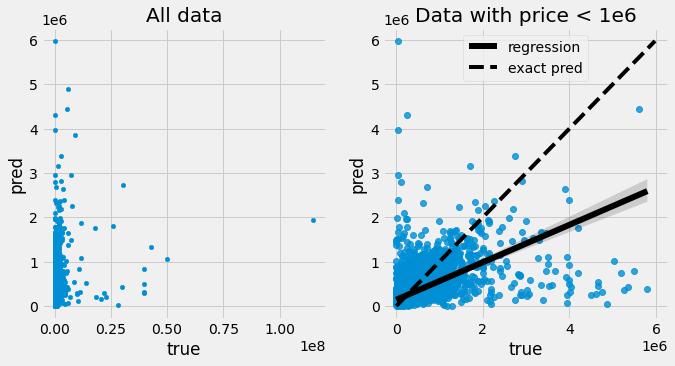

In [21]:
%%time
device = get_default_device()

input_size = train.shape[1] - len(emb_info['embedded_col_names']) - 1 # price
print('n continues features:', input_size)

params_neptune = dict(loss_function = 'MAE',
                      iterations = 20,
                      batch_size = 264,
                      learning_rate = 0.01, #0.05,
                      l2_reg=0.1,
                      n_features = input_size + np.sum([x[1] for x in emb_info['embedding_sizes']])
             )
cv_folds = TimeSeriesSplit(n_splits=5)

model = EmbeddingNNModel(emb_info['embedding_sizes'], input_size)
model.apply(init_weights)

print('n features:', input_size + np.sum([x[1] for x in emb_info['embedding_sizes']]))
optimizer = optim.Adam(model.parameters(), 
                       lr=params_neptune['learning_rate'],
                       weight_decay=params_neptune['l2_reg']
                      )

# m = model_NN_emb(train, val,model, emb_info, params_neptune, optimizer, 
#                  flag_neptune=False)
m,t,v = model_NN_emb_cv(df, df_test, model, cv_folds, 
                        params_neptune,optimizer, False)


<AxesSubplot:>

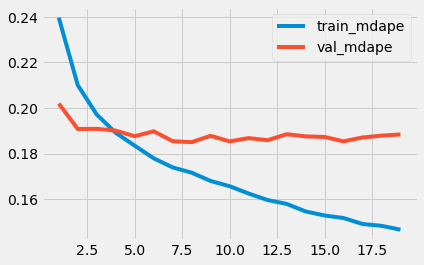

In [24]:
f = ['train_loss', 'train_mdape', 'val_loss','val_mdape']
d = np.concatenate([t, v], axis=0)
res = pd.DataFrame(d.mean(axis=2).T , columns=f)
res[res.train_mdape < 1][['train_mdape', 'val_mdape']].plot()

In [ ]:
run = neptune.init(project='declot/Enbysis-UK-Rental', 
                            api_token=NEPTUNE_API_TOKEN,
                            source_files=['3_nn_embedding.ipynb', 'requirements.txt'])
run['parameters'] = params_neptune
run["sys/tags"].add(['NN embed', 'NN', 'cross-val'])
run['model'] = model

def log_neptune(x, name):
    run[name].log(x)
    
res.train_loss.apply(log_neptune, name='loss/train')
res.train_mdape.apply(log_neptune, name='mdape/train')
res.val_loss.apply(log_neptune, name='loss/val')
res.val_mdape.apply(log_neptune, name='mdape/val')
run['val/mdape'] = np.min(res.val_mdape)
run['cv/mdape_iter'] = np.argmin(res.val_mdape) + 1
run.stop()

In [23]:
# get preds for submittion
params_neptune['iterations'] = 10

model.apply(init_weights)
test_dl = get_dataloader(test, embedding_col_names, batch_size=params_neptune['batch_size'],
                        device=device, flag_train=False)
data  = pd.concat([train, val], axis=0)
data_dl = get_dataloader(data, embedding_col_names, batch_size=params_neptune['batch_size'],
                        device=device, flag_train=True)

train_loop(model, data_dl, None, params_neptune, optimizer,
            flag_neptune=False, flag_val=False)

preds = get_prediction(test, model, embedding_col_names)
get_submittion(preds, df_test)

(28323, 12) (28323, 24) (28323, 1)
(100000, 12) (100000, 24) (100000, 1)
	train			val
	loss	mdape		loss	mdape
(  0) 1.62e+05	2.2658e+03
(  1) 1.31e+05	1.8203e-01
(  2) 1.27e+05	1.7067e-01
(  3) 1.25e+05	1.6000e-01
(  4) 1.23e+05	1.5719e-01
(  5) 1.21e+05	1.5319e-01
(  6) 1.21e+05	1.5073e-01
(  7) 1.19e+05	1.4902e-01
(  8) 1.19e+05	1.4766e-01
(  9) 1.17e+05	1.4514e-01
(28323, 12) (28323, 24) (28323, 1)


# Final model on full dataset

In [25]:
# idx = list(cv_folds.split(df, df.price))[-1]
idx = None

train = df_ini.copy()
# np.random.seed(2021)
# indexes = np.random.choice(np.arange(0, df_ini.shape[0]),
#                                 size=500_000, replace=False)
# train = df_ini.iloc[indexes]

train, _, test, features_cat, emb_info = preprocess_total(train, df_test, idx)
features = features_str + features_address #+ ['price']
train.drop(features, axis=1, inplace=True)
test.drop(features, axis=1, inplace=True)

assert (train.isna().sum() == 0).all()
assert (test.drop('price', axis=1).isna().sum() == 0).all()

embedding_col_names = emb_info['embedded_col_names']

15 3 5 22 45
15 3 5 21 44
# features in ohe: 8778
# features in embedding: 146


In [26]:
params_neptune['iterations'] = 10

model = EmbeddingNNModel(emb_info['embedding_sizes'], input_size)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), 
                       lr=params_neptune['learning_rate'],
                       weight_decay=params_neptune['l2_reg']
                      )
test_dl = get_dataloader(test, embedding_col_names, batch_size=params_neptune['batch_size'],
                        device=device, flag_train=False)
# data  = pd.concat([train, val], axis=0)
data_dl = get_dataloader(train, embedding_col_names, batch_size=params_neptune['batch_size'],
                        device=device, flag_train=True)

train_loop(model, data_dl, None, params_neptune, optimizer,
            flag_neptune=False, flag_val=False)

(28323, 12) (28323, 24) (28323, 1)
(1978777, 12) (1978777, 24) (1978777, 1)
	train			val
	loss	mdape		loss	mdape
(  0) 1.32e+05	6.4316e+01
(  1) 1.25e+05	1.6433e-01
(  2) 1.23e+05	1.6014e-01
(  3) 1.22e+05	1.5780e-01
(  4) 1.21e+05	1.5663e-01
(  5) 1.21e+05	1.5594e-01
(  6) 1.21e+05	1.5563e-01
(  7) 1.21e+05	1.5519e-01
(  8) 1.21e+05	1.5481e-01
(  9) 1.20e+05	1.5458e-01


(array([[1.32351690e+05, 1.25070794e+05, 1.23172178e+05, 1.22026072e+05,
         1.21463595e+05, 1.21149703e+05, 1.20919662e+05, 1.20700483e+05,
         1.20516920e+05, 1.20383445e+05],
        [6.43161886e+01, 1.64329012e-01, 1.60138877e-01, 1.57795921e-01,
         1.56625652e-01, 1.55939283e-01, 1.55630575e-01, 1.55188169e-01,
         1.54812665e-01, 1.54584390e-01]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [27]:
preds = get_prediction(test, model, embedding_col_names)
get_submittion(preds, df_test)

(28323, 12) (28323, 24) (28323, 1)


In [28]:
preds.isna().sum(), preds

(0,
 0        223975.171875
 1        119934.328125
 2         96979.015625
 3         75063.851562
 4         67556.679688
              ...      
 28318     40095.984375
 28319    155393.562500
 28320    126704.984375
 28321    186529.562500
 28322    172179.031250
 Length: 28323, dtype: float64)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e0716c79-cd49-421b-b62e-acc802240d39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>